<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-group-photo/blob/master/test_matches_faceswap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install RISE

In [9]:
## ENABLE GPU TO WORK

import cv2
import dlib
from google.colab.patches import cv2_imshow

!wget -q  https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
!wget -q https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
!ls -l

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
facerec = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.
bzip2: Output file dlib_face_recognition_resnet_model_v1.dat already exists.
total 214024
-rw-r--r-- 1 root root 22466066 Dec  9 19:55 dlib_face_recognition_resnet_model_v1.dat
-rw-r--r-- 1 root root 21428389 Dec  9 20:06 dlib_face_recognition_resnet_model_v1.dat.bz2
-rw-r--r-- 1 root root  2922692 Dec  9 19:53 IMG_20191112_110956.jpg
-rw-r--r-- 1 root root  2922692 Dec  9 19:55 IMG_20191112_110956.jpg.1
-rw-r--r-- 1 root root  2831264 Dec  9 19:53 IMG_20191112_111007.jpg
-rw-r--r-- 1 root root  2831264 Dec  9 19:55 IMG_20191112_111007.jpg.1
drwxr-xr-x 1 root root     4096 Dec  6 16:53 sample_data
-rw-r--r-- 1 root root 99693937 Dec  9 19:55 shape_predictor_68_face_landmarks.dat
-rw-r--r-- 1 root root 64040097 Dec  9 20:05 shape_predictor_68_face_landmarks.dat.bz2


In [0]:
def swap_faces(a,b, input, src_img, dst_img):
  # Select src face
  src_points, src_shape, src_face = select_face(src_img,a)
  # Select dst face
  dst_points, dst_shape, dst_face = select_face(dst_img,b)

  h, w = dst_face.shape[:2]

  ### Warp Image
  #if not args.warp_2d:
      ## 3d warp
    #   warped_src_face = warp_image_3d(src_face, src_points[:48], dst_points[:48], (h, w))
  #else:
    ## 2d warp

  src_mask = mask_from_points(src_face.shape[:2], src_points)
  src_face = apply_mask(src_face, src_mask)

  # Correct Color for 2d warp
  warped_dst_img = warp_image_3d(dst_face, dst_points[:48], src_points[:48], src_face.shape[:2])
  src_face = correct_colours(warped_dst_img, src_face, src_points)

  # Warp
  warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (h, w, 3))

  ## Mask for blending
  mask = mask_from_points((h, w), dst_points)
  mask_src = np.mean(warped_src_face, axis=2) > 0
  mask = np.asarray(mask*mask_src, dtype=np.uint8)

  ## Correct color
  warped_src_face = apply_mask(warped_src_face, mask)
  #print("Das ist Person " + str(a))
  #cv2_imshow(warped_src_face)
  dst_face_masked = apply_mask(dst_face, mask)
  #cv2_imshow(dst_face_masked)
  warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)
  #cv2_imshow(warped_src_face)

  ## Shrink the mask
  kernel = np.ones((10, 10), np.uint8)
  mask = cv2.erode(mask, kernel, iterations=1)

  ##Poisson Blending
  r = cv2.boundingRect(mask)
  center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
  output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

  x, y, w, h = dst_shape
  dst_img_cp = dst_img.copy()
  dst_img_cp[y:y+h, x:x+w] = output
  output = dst_img_cp

  ##For debug
  #cv2_imshow(src_img)
  #cv2_imshow(dst_img)
  #cv2_imshow(output)

  return output


In [0]:
import cv2
import numpy as np
import scipy.spatial as spatial
import logging
import matplotlib.pyplot as plt

## 3D Transform
def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0 + 1]
    q12 = img[y0 + 1, x0]
    q22 = img[y0 + 1, x0 + 1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points):
    """ x,y grid coordinates within the ROI of supplied points
    :param points: points to generate grid coordinates
    :returns: array of (x, y) coordinates
    """
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1

    return np.asarray([(x, y) for y in range(ymin, ymax)
                       for x in range(xmin, xmax)], np.uint32)


def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    """
    Warp each triangle from the src_image only within the
    ROI of the destination image (points in dst_points).
    """
    roi_coords = grid_coordinates(dst_points)
    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None


def triangular_affine_matrices(vertices, src_points, dst_points):
    """
    Calculate the affine transformation matrix for each
    triangle (x,y) vertex from dst_points to src_points
    :param vertices: array of triplet indices to corners of triangle
    :param src_points: array of [x, y] points to landmarks for source image
    :param dst_points: array of [x, y] points to landmarks for destination image
    :returns: 2 x 3 affine matrix transformation for a triangle
    """
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dst_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat


def warp_image_3d(src_img, src_points, dst_points, dst_shape, dtype=np.uint8):
    rows, cols = dst_shape[:2]
    result_img = np.zeros((rows, cols, 3), dtype=dtype)

    delaunay = spatial.Delaunay(dst_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
        delaunay.simplices, src_points, dst_points)))

    process_warp(src_img, result_img, tri_affines, dst_points, delaunay)

    return result_img


## 2D Transform
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(np.dot(points1.T, points2))
    R = (np.dot(U, Vt)).T

    return np.vstack([np.hstack([s2 / s1 * R,
                                (c2.T - np.dot(s2 / s1 * R, c1.T))[:, np.newaxis]]),
                      np.array([[0., 0., 1.]])])


def warp_image_2d(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)

    return output_im


## Generate Mask
def mask_from_points(size, points,erode_flag=1):
    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    #print('mask')
    #cv2_imshow(mask)
    if erode_flag:
        mask = cv2.erode(mask, kernel,iterations=1)
        #print('eroded mask')
        #cv2_imshow(mask)

    return mask


## Color Correction
def correct_colours(im1, im2, landmarks1):
    COLOUR_CORRECT_BLUR_FRAC = 0.75
    LEFT_EYE_POINTS = list(range(42, 48))
    RIGHT_EYE_POINTS = list(range(36, 42))
    #print('correct_colours: \n')
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    
    # kernel doesn't have center.
    if blur_amount % 2 == 0:
        blur_amount += 1
    
    #print('blured')
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    #cv2_imshow(im1_blur)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
    #cv2_imshow(im2_blur)

    #print('as int')
    # Avoid divide-by-zero errors.
    im2_blur = im2_blur.astype(int)
    #cv2_imshow(im2_blur)
    im2_blur += 128*(im2_blur <= 1)
    #cv2_imshow(im2_blur)

    #print('results')
    result = im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64)
    #print('result as float64')
    #cv2_imshow(result)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result


## Copy-and-paste
def apply_mask(img, mask):
    """ Apply mask to supplied image
    :param img: max 3 channel image
    :param mask: [0-255] values in mask
    :returns: new image with mask applied
    """
    masked_img=cv2.bitwise_and(img,img,mask=mask)

    return masked_img


## Alpha blending
def alpha_feathering(src_img, dest_img, img_mask, blur_radius=15):
    mask = cv2.blur(img_mask, (blur_radius, blur_radius))
    mask = mask / 255.0

    result_img = np.empty(src_img.shape, np.uint8)
    for i in range(3):
        result_img[..., i] = src_img[..., i] * mask + dest_img[..., i] * (1-mask)

    return result_img


def check_points(img,points):
    # Todo: I just consider one situation.
    if points[8,1]>img.shape[0]:
        logging.error("Jaw part out of image")
    else:
        return True
    return False

# Can be optimized by giving the face instead of the whole picture
def select_face(im, a, r=10):
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = detector(img_gray, 0)

    if len(faces) == 0:
      print('Detected 0 Faces !!!')
      
    if len(faces) == 1:
      bbox = faces[0]
    else:
      bbox = []
      im_copy = im.copy()
      for face in faces:
          # draw the face bounding box
          cv2.rectangle(im_copy, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
      #bbox = bbox[0]

    # Always takes first face found in picture!!
    landmarks = predictor(img_gray, faces[a])
    points = np.asarray(list([p.x, p.y] for p in landmarks.parts()), dtype=np.int)

    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)

    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def get_face_matrices(dlib_img):
  faces = detector(dlib_img, 2)

  face_matrices = []
  for k, d in enumerate(faces):
    shape = predictor(dlib_img,d)
    face_descriptor = facerec.compute_face_descriptor(dlib_img,shape)
    face_matrices.append(face_descriptor)

  return face_matrices

def euclid_distance(a,b):
  return np.linalg.norm(np.asarray(a)-np.asarray(b))

def get_matches(img1, img2):
  first_image = dlib.load_rgb_image(img1)
  second_image = dlib.load_rgb_image(img2)

  first_image_matrix = get_face_matrices(first_image)
  print(first_image_matrix)
  second_image_matrix = get_face_matrices(second_image)

  matches = []
  for x in range(len(first_image_matrix)):
    for i in range(len(second_image_matrix)):
      if euclid_distance(first_image_matrix[x],second_image_matrix[i]) < 0.6:
        matches.append((x,i))
    
  return matches 

def resize_img_by_scale(img, scale):
  h, w, c = img.shape
  img_resize = cv2.resize(img,(int(w/scale),int(h/scale)))
  return img_resize

Gesicht Nr: 0


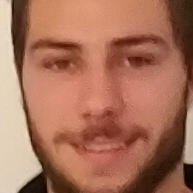

Gesicht Nr: 1


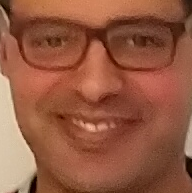

Gesicht Nr: 2


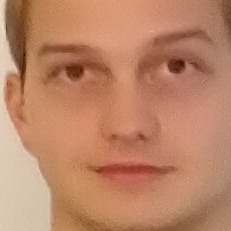

Gesicht Nr: 3


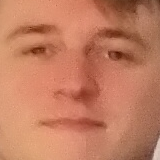

Gesicht Nr: 0


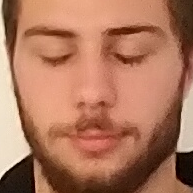

Gesicht Nr: 1


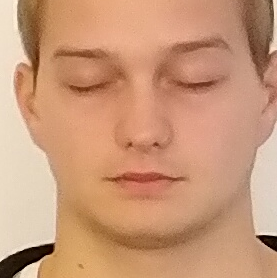

Gesicht Nr: 2


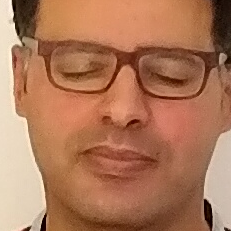

Gesicht Nr: 3


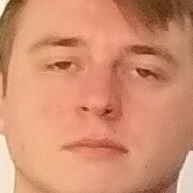

[(0, 0), (1, 2), (2, 1), (3, 3)]


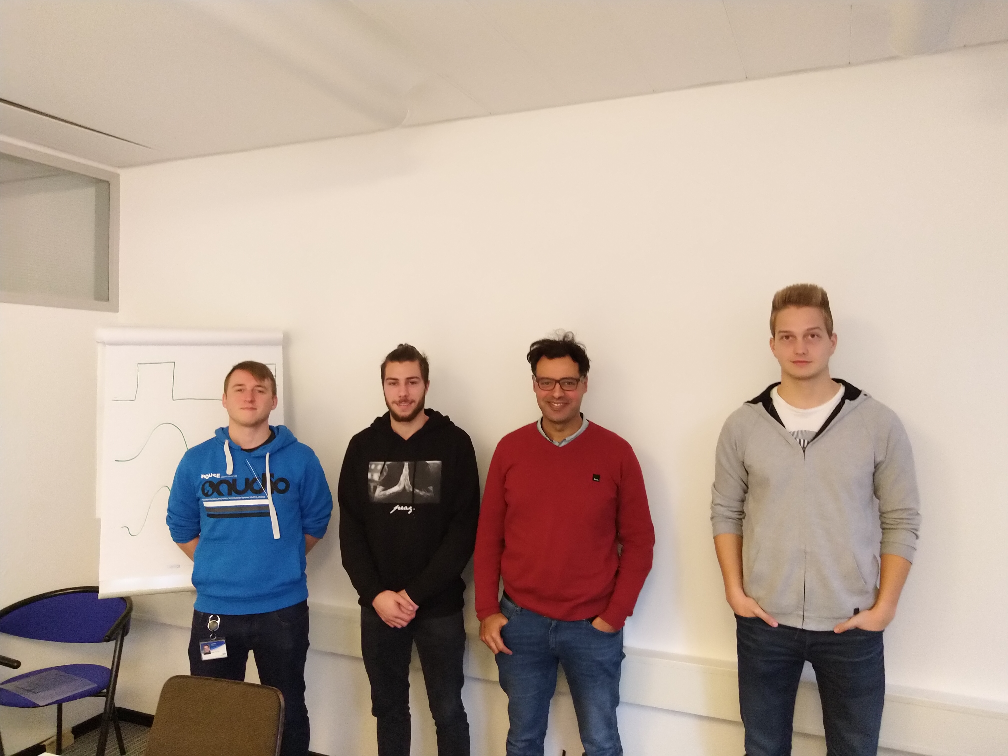

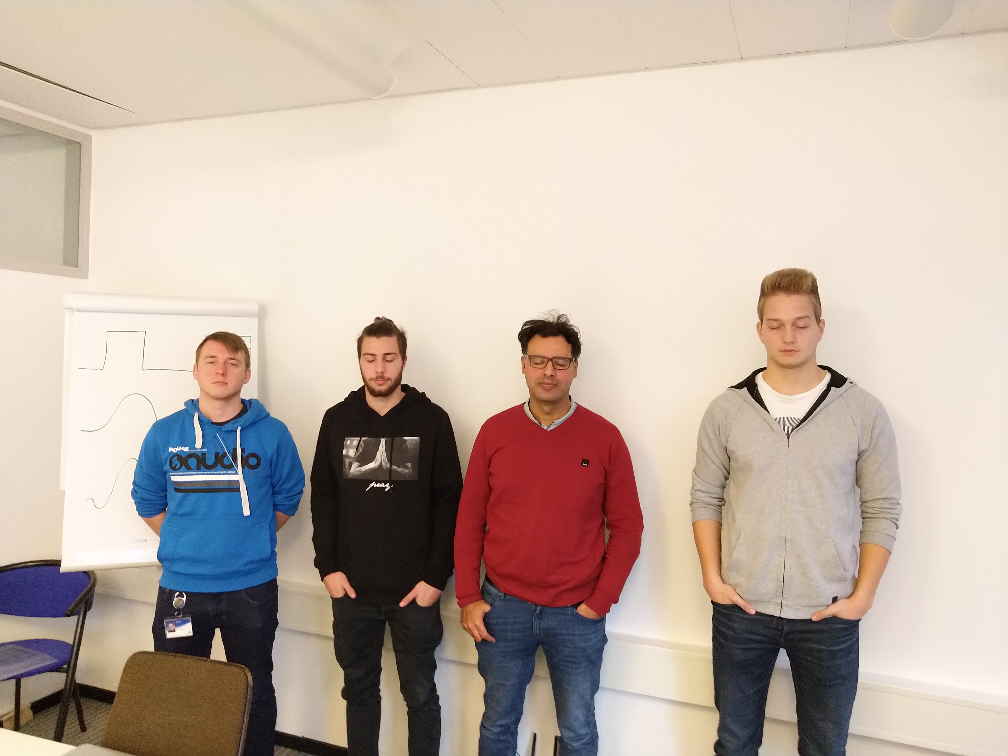

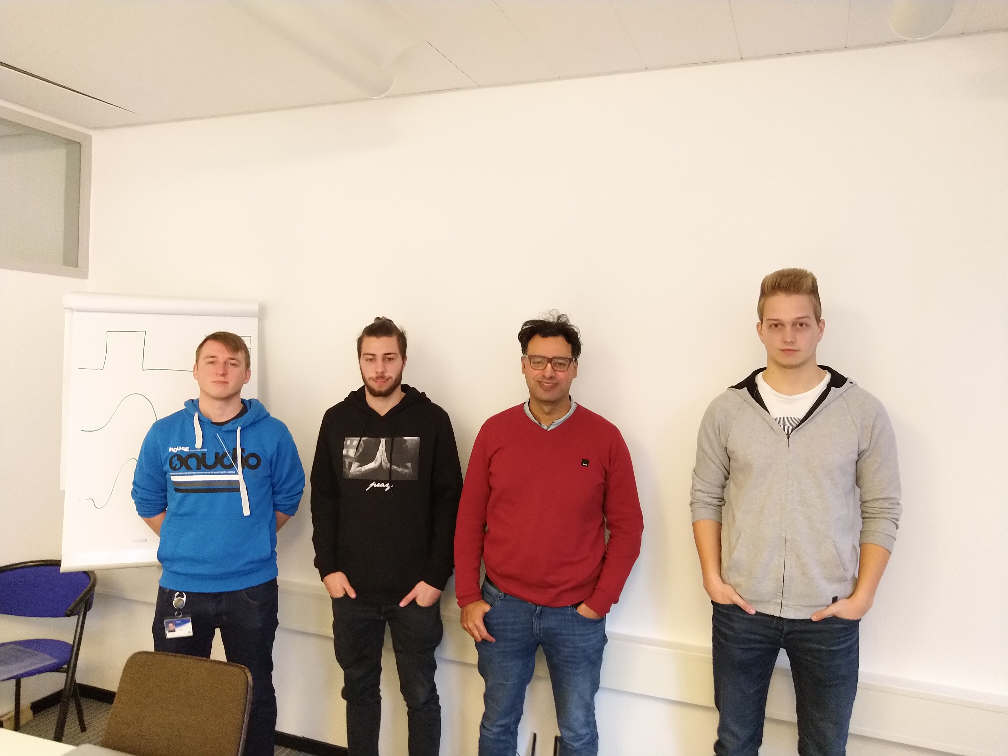

In [12]:
# Read images
!wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-group-photo/master/pictures/group_1/IMG_20191112_110956.jpg
!wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-group-photo/master/pictures/group_1/IMG_20191112_111007.jpg

src_img_dlib = dlib.load_rgb_image("IMG_20191112_110956.jpg")
dst_img_dlib = dlib.load_rgb_image('IMG_20191112_111007.jpg')

scr_img = cv2.imread('IMG_20191112_110956.jpg')
dst_img = cv2.imread('IMG_20191112_111007.jpg')

src_faces = detector(src_img_dlib, 2)
dst_faces = detector(dst_img_dlib, 2)

for i in range(len(src_faces)):
  print("Gesicht Nr: "+str(i))
  #cv2_imshow(dlib_img, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
  #y, h, x, w = src_faces[i]
  x = src_faces[i].left()
  y = src_faces[i].top()
  w = src_faces[i].right()-x
  h = src_faces[i].bottom()-y
  crop_img = scr_img[y:y+h, x:x+w]
  cv2_imshow(crop_img)

for i in range(len(dst_faces)):
  print("Gesicht Nr: "+str(i))
  #cv2_imshow(dlib_img, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
  #y, h, x, w = src_faces[i]
  x = dst_faces[i].left()
  y = dst_faces[i].top()
  w = dst_faces[i].right()-x
  h = dst_faces[i].bottom()-y
  crop_img = dst_img[y:y+h, x:x+w]
  cv2_imshow(crop_img)

def get_face_matrices(dlib_img):
  faces = detector(dlib_img, 2)

  face_matrices = []
  for k, d in enumerate(faces):
    shape = predictor(dlib_img,d)
    face_descriptor = facerec.compute_face_descriptor(dlib_img,shape)
    face_matrices.append(face_descriptor)

  return face_matrices

def euclid_distance(a,b):
  return np.linalg.norm(np.asarray(a)-np.asarray(b))

def get_matches(img1, img2):
  first_image = dlib.load_rgb_image(img1)
  second_image = dlib.load_rgb_image(img2)

  first_image_matrix = get_face_matrices(first_image)
  second_image_matrix = get_face_matrices(second_image)

  matches = []
  for x in range(len(first_image_matrix)):
    for i in range(len(second_image_matrix)):
      if euclid_distance(first_image_matrix[x],second_image_matrix[i]) < 0.6:
        matches.append((x,i))
    
  return matches   

matches = get_matches('IMG_20191112_110956.jpg', 'IMG_20191112_111007.jpg')
print(matches)

output = dst_img

for match in matches:
  a,b = match
  output = swap_faces(a,b,dst_img,scr_img)

cv2_imshow(resize_img_by_scale(scr_img, 4))
cv2_imshow(resize_img_by_scale(dst_img, 4))
cv2_imshow(resize_img_by_scale(output, 4))
